In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import gc
from importlib import reload

In [2]:
import data
import analysis
import ratios_fit
import jackknife as jk

# Load Data

In [32]:
# Since measurements can take up a lot of memory, deleting old data before loading more can prevent a crash
try:
    del measurements
    gc.collect()
except:
    pass

# Parameters
Nt = 200
dt = 0.1

alpha = 0.8
beta = 9.0
barrier_strength = 100.0
FV_offset = 0.3
TV_offset = 0.0
eps = 1e-10

#t_full1 = 2
#t_full2 = "*"

M = "*"
L = "*"
t_FV = "*"

version = "13-1"
date = "*"
#date = "2025-04-01" #datetime.datetime.now().date()

cutoff = 10000
block_size = 2000

measurements = data.Data(cutoff, block_size)

fileid = f"{1}x{Nt}_alpha_{alpha}_beta_{beta}_dt_{dt}_FVoff_{FV_offset}_TVoff_{TV_offset}_bar_{barrier_strength}_M_{M}_L_{L}_eps_{eps}_*_tFV_{t_FV}_*_{date}_{version}"
print(fileid)
#measurements.load(f"../../../data/measurements_{fileid}.bin")
measurements.load(f"output_data/measurements_{fileid}.bin")

1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_*_L_*_eps_1e-10_*_tFV_*_*_*_13-1
Loading output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.008_eps_1e-10_offL_False_offM_False_tTV_4_tFV_194_tFVout_72_tFVmid_50_2025-10-10_13-1.bin ...
Loading output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_10_tFV_188_tFVout_69_tFVmid_50_2025-10-10_13-1.bin ...
Loading output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.02_eps_1e-10_offL_False_offM_False_tTV_4_tFV_194_tFVout_72_tFVmid_50_2025-10-10_13-1.bin ...
Loading output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_0.04_L_1.0_eps_1e-10_offL_False_offM_False_tTV_4_tFV_194_tFVout_72_tFVmid_50_2025-10-10_13-1.bin ...
Loading output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_0.02_L_1.0_ep

Check to make sure that the data look reasonable

In [33]:
reload(analysis)
an = analysis.Analysis(measurements)

an.check_data()

400


(-1.0, 2.5)

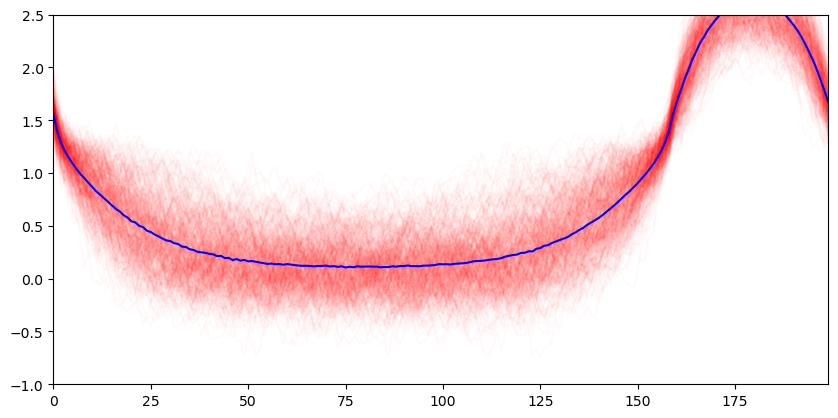

In [34]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(10)
an.data.cutoff=10000
params = {"tTV": 40, "offL": False, "offM": False, "M": 1.0, "L": 1.0, "Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength}
#params2 = {"tTV": 0, "offL": False, "offM": False, "M": 1.0, "L": 0.0, "Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength}

#an.plot_potential(params, xmin=-1, xmax=2.5, fig=fig, ax=ax, cmap="viridis", vmin=-20, vmax=3)
#an.plot_potential_diff(params, params2, xmin=0.8, xmax=2.5, fig=fig, ax=ax, cmap="viridis")
an.plot_paths(params, sampling_freq = 100, cutoff=10000, ax=ax, alpha=0.02)
an.plot_mean_path(params, ax=ax, color="blue")
ax.set_xlim([0,199])
ax.set_ylim([-1,2.5])

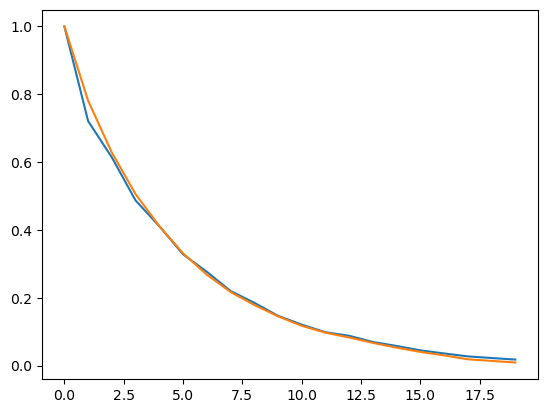

In [35]:
params = {"tTV": 2, "M": 1.0, "L": 1.0, "Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength}
sf = an.data.get_indices(params)[0]

autocorr_psq = an.autocorr(np.array(an.data.psq_list[sf])[10000:])
plt.plot(autocorr_psq[:20])
autocorr_phi = an.autocorr(np.array(an.data.phi_list[sf])[10000:,0])
plt.plot(autocorr_phi[:20])

# Analysis

In [36]:
# Old data (add 0.8 to t_TVs to match with new data
#t_TVs_sch = [0.,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98,1.,1.02,1.04,1.06,1.08,1.1,1.12,1.14,1.16,1.18,1.2,1.22,1.24,1.26,1.28,1.3,1.32,1.34,1.36,1.38,1.4,1.42,1.44,1.46,1.48,1.5,1.52,1.54,1.56,1.58,1.6,1.62,1.64,1.66,1.68,1.7,1.72,1.74,1.76,1.78,1.8,1.82,1.84,1.86,1.88,1.9,1.92,1.94,1.96,1.98,2.,2.02,2.04,2.06,2.08,2.1,2.12,2.14,2.16,2.18,2.2,2.22,2.24,2.26,2.28,2.3,2.32,2.34,2.36,2.38,2.4,2.42,2.44,2.46,2.48,2.5,2.52,2.54,2.56,2.58,2.6,2.62,2.64,2.66,2.68,2.7,2.72,2.74,2.76,2.78,2.8,2.82,2.84,2.86,2.88,2.9,2.92,2.94,2.96,2.98,3.,3.02,3.04,3.06,3.08,3.1,3.12,3.14,3.16,3.18,3.2,3.22,3.24,3.26,3.28,3.3,3.32,3.34,3.36,3.38,3.4,3.42,3.44,3.46,3.48,3.5,3.52,3.54,3.56,3.58,3.6,3.62,3.64,3.66,3.68,3.7,3.72,3.74,3.76,3.78,3.8,3.82,3.84,3.86,3.88,3.9,3.92,3.94,3.96,3.98,4.,4.02,4.04,4.06,4.08,4.1,4.12,4.14,4.16,4.18,4.2,4.22,4.24,4.26,4.28,4.3,4.32,4.34,4.36,4.38,4.4,4.42,4.44,4.46,4.48,4.5,4.52,4.54,4.56,4.58,4.6,4.62,4.64,4.66,4.68,4.7,4.72,4.74,4.76,4.78,4.8,4.82,4.84,4.86,4.88,4.9,4.92,4.94,4.96,4.98,5.,5.02,5.04,5.06,5.08,5.1,5.12,5.14,5.16,5.18,5.2,5.22,5.24,5.26,5.28,5.3,5.32,5.34,5.36,5.38,5.4,5.42,5.44,5.46,5.48,5.5,5.52,5.54,5.56,5.58,5.6,5.62,5.64,5.66,5.68,5.7,5.72,5.74,5.76,5.78,5.8,5.82,5.84,5.86,5.88,5.9,5.92,5.94,5.96,5.98,6.,]
#ddR_div_ddR_a_1_b_9 = [1.05703835,1.0558753,1.05475349,1.05367054,1.05262427,1.05161264,1.05063378,1.04968597,1.04876758,1.04787713,1.04701322,1.04617165,1.04535358,1.04455784,1.04378335,1.04302908,1.04229408,1.04157743,1.0408783,1.04019588,1.03952942,1.03887821,1.03824158,1.0376189,1.03700957,1.03641302,1.03582872,1.03525617,1.03469486,1.03414437,1.03360423,1.03307406,1.03255345,1.03204203,1.03153944,1.03104536,1.03055945,1.03008142,1.02961096,1.02914782,1.02869171,1.02824238,1.0277996,1.02736314,1.02693277,1.02650828,1.02608948,1.02567618,1.02526818,1.02486532,1.02446743,1.02407435,1.02368593,1.02330202,1.02292248,1.02254718,1.02217599,1.02180879,1.02144546,1.02108589,1.02072997,1.02037761,1.0200287,1.01968315,1.01934087,1.01900178,1.01866579,1.01833282,1.0180028,1.01767566,1.01735133,1.01702973,1.01671082,1.01639453,1.01608079,1.01576956,1.01546079,1.01515441,1.01485039,1.01454867,1.01424921,1.01395197,1.0136569,1.01336398,1.01307315,1.01278439,1.01249765,1.01221291,1.01193014,1.01164929,1.01137035,1.01109329,1.01081807,1.01054468,1.01027308,1.01000326,1.00973519,1.00946884,1.0092042,1.00894125,1.00867997,1.00842033,1.00816232,1.00790592,1.00765112,1.0073979,1.00714624,1.00689613,1.00664755,1.00640049,1.00615493,1.00591087,1.00566828,1.00542716,1.0051875,1.00494928,1.00471249,1.00447712,1.00424316,1.0040106,1.00377944,1.00354965,1.00332123,1.00309417,1.00286846,1.0026441,1.00242107,1.00219937,1.00197898,1.0017599,1.00154213,1.00132565,1.00111045,1.00089654,1.00068389,1.00047251,1.00026238,1.00005351,0.99984588,0.99963948,0.99943431,0.99923037,0.99902764,0.99882612,0.99862581,0.99842669,0.99822876,0.99803201,0.99783645,0.99764205,0.99744882,0.99725675,0.99706584,0.99687607,0.99668744,0.99649995,0.99631359,0.99612835,0.99594423,0.99576122,0.99557932,0.99539852,0.99521881,0.9950402,0.99486267,0.99468621,0.99451083,0.99433651,0.99416326,0.99399106,0.99381991,0.99364981,0.99348074,0.99331271,0.9931457,0.99297972,0.99281475,0.99265079,0.99248784,0.99232589,0.99216493,0.99200496,0.99184597,0.99168797,0.99153093,0.99137486,0.99121975,0.9910656,0.9909124,0.99076014,0.99060882,0.99045844,0.99030898,0.99016045,0.99001284,0.98986614,0.98972034,0.98957545,0.98943145,0.98928835,0.98914613,0.98900479,0.98886432,0.98872473,0.988586,0.98844813,0.98831111,0.98817494,0.98803961,0.98790513,0.98777147,0.98763864,0.98750664,0.98737545,0.98724508,0.98711551,0.98698674,0.98685877,0.9867316,0.98660521,0.9864796,0.98635476,0.9862307,0.98610741,0.98598487,0.9858631,0.98574207,0.98562179,0.98550226,0.98538346,0.98526539,0.98514805,0.98503143,0.98491553,0.98480034,0.98468586,0.98457208,0.984459,0.98434662,0.98423492,0.98412391,0.98401357,0.98390392,0.98379493,0.98368661,0.98357895,0.98347194,0.98336559,0.98325989,0.98315483,0.9830504,0.98294662,0.98284346,0.98274093,0.98263902,0.98253772,0.98243704,0.98233697,0.9822375,0.98213863,0.98204036,0.98194268,0.98184558,0.98174907,0.98165314,0.98155778,0.981463,0.98136878,0.98127512,0.98118202,0.98108948,0.98099749,0.98090604,0.98081514,0.98072478,0.98063495,0.98054566,0.98045689,0.98036864,0.98028092,0.98019371,0.98010702,0.98002083,0.97993515,0.97984998,0.9797653,0.97968111,0.97959742,0.97951422,0.97943149,0.97934925,0.97926749,0.9791862,0.97910538,0.97902503,0.97894514,0.97886571,0.97878674,0.97870822,0.97863015,0.97855253]
#dR_div_ddR_a_9_b_9 = [0.99983976,0.99814939,0.99648836,0.99485429,0.99324496,0.99165833,0.99009251,0.98854572,0.98701632,0.98550278,0.98400368,0.98251565,0.98103914,0.97957297,0.97811602,0.97666726,0.97522571,0.97379045,0.97236064,0.97093547,0.96951418,0.96809606,0.96668045,0.96526672,0.96385431,0.96244265,0.96103124,0.9596196,0.9582073,0.95679391,0.95537906,0.9539624,0.9525436,0.95112235,0.9496984,0.94827149,0.9468414,0.94540793,0.94397091,0.94253018,0.94108561,0.93963709,0.93818455,0.93672789,0.93526709,0.93380211,0.93233295,0.9308596,0.92938211,0.92790051,0.92641488,0.92492529,0.92343184,0.92193464,0.92043383,0.91892954,0.91742195,0.91591122,0.91439754,0.91288112,0.91136218,0.90984093,0.90831762,0.9067925,0.90526584,0.90373791,0.90220899,0.90067937,0.89914936,0.89761927,0.89608941,0.8945601,0.89303168,0.89150447,0.88997883,0.8884551,0.88693361,0.88541474,0.88389881,0.88238621,0.88087727,0.87937235,0.87787182,0.87637602,0.8748853,0.87340003,0.87192054,0.87044718,0.86898029,0.86752021,0.86606727,0.86462178,0.86318408,0.86175447,0.86033326,0.85892075,0.85751722,0.85612296,0.85473824,0.85336332,0.85199846,0.85064391,0.84929989,0.84796664,0.84664436,0.84533328,0.84403357,0.84274542,0.84146901,0.8402045,0.83895204,0.83771178,0.83648384,0.83526835,0.83406541,0.83287512,0.83169758,0.83053286,0.82938103,0.82824214,0.82711626,0.82600342,0.82490365,0.82381697,0.82274339,0.82168292,0.82063555,0.81960128,0.81858007,0.81757191,0.81657675,0.81559456,0.81462528,0.81366887,0.81272525,0.81179436,0.81087613,0.80997048,0.80907733,0.80819658,0.80732815,0.80647193,0.80562783,0.80479574,0.80397554,0.80316714,0.80237041,0.80158524,0.8008115,0.80004908,0.79929784,0.79855767,0.79782843,0.79710999,0.79640223,0.79570501,0.79501819,0.79434164,0.79367523,0.79301883,0.79237229,0.79173548,0.79110827,0.79049051,0.78988208,0.78928283,0.78869264,0.78811137,0.78753888,0.78697504,0.78641972,0.78587279,0.78533411,0.78480356,0.78428101,0.78376632,0.78325938,0.78276006,0.78226823,0.78178378,0.78130657,0.7808365,0.78037343,0.77991726,0.77946787,0.77902514,0.77858897,0.77815924,0.77773583,0.77731865,0.77690759,0.77650253,0.77610339,0.77571004,0.77532241,0.77494038,0.77456386,0.77419275,0.77382696,0.77346639,0.77311096,0.77276058,0.77241515,0.77207459,0.77173882,0.77140775,0.7710813,0.77075938,0.77044193,0.77012885,0.76982008,0.76951554,0.76921515,0.76891885,0.76862655,0.7683382,0.76805372,0.76777304,0.7674961,0.76722284,0.76695318,0.76668708,0.76642446,0.76616526,0.76590944,0.76565692,0.76540766,0.76516159,0.76491866,0.76467882,0.76444202,0.7642082,0.76397732,0.76374932,0.76352415,0.76330178,0.76308214,0.76286519,0.7626509,0.76243921,0.76223008,0.76202348,0.76181935,0.76161765,0.76141836,0.76122142,0.7610268,0.76083446,0.76064436,0.76045647,0.76027076,0.76008718,0.7599057,0.75972629,0.75954892,0.75937355,0.75920015,0.75902869,0.75885914,0.75869147,0.75852565,0.75836165,0.75819945,0.75803901,0.75788031,0.75772331,0.75756801,0.75741436,0.75726234,0.75711194,0.75696312,0.75681586,0.75667013,0.75652592,0.7563832,0.75624195,0.75610215,0.75596378,0.7558268,0.75569122,0.755557,0.75542412,0.75529256,0.75516232,0.75503336,0.75490566,0.75477922,0.75465401,0.75453002,0.75440722,0.75428561,0.75416515,0.75404585,0.75392768,0.75381062,0.75369467,0.7535798,0.753466,0.75335326,0.75324156,0.75313089]
#ddR_div_ddR_a_8_b_9 = [0.9530439,0.95064323,0.94824821,0.94585586,0.94346339,0.94106812,0.93866752,0.93625914,0.93384065,0.93140981,0.92896445,0.92650097,0.92401865,0.92151551,0.91898965,0.91643922,0.91386241,0.91125745,0.90862262,0.90595625,0.90325669,0.90052235,0.89775164,0.89494305,0.89209508,0.88920627,0.8862752,0.88330048,0.88028079,0.8772148,0.87410128,0.87093901,0.86772684,0.86446367,0.86114845,0.8577802,0.85435801,0.85088104,0.84734852,0.84375978,0.84011423,0.83641136,0.8326508,0.82883224,0.82495553,0.82102061,0.81702757,0.81297662,0.80886813,0.8047026,0.80048069,0.79620324,0.79187122,0.78748581,0.78304834,0.77856033,0.77402348,0.76943967,0.76481098,0.76013965,0.75542813,0.75067903,0.74589514,0.74107943,0.73623503,0.73136523,0.72647345,0.72156327,0.71663837,0.71170257,0.70675974,0.70181389,0.69686903,0.69192927,0.6869987,0.68208146,0.67718166,0.67230338,0.66745066,0.66262746,0.65783769,0.65308513,0.64837345,0.64370619,0.63908675,0.63451836,0.63000409,0.62554683,0.62114927,0.61681391,0.61254307,0.60833884,0.60420311,0.60013758,0.59614372,0.59222281,0.58837593,0.58460397,0.58090762,0.57728738,0.57374359,0.57027642,0.56688586,0.56357178,0.56033387,0.55717173,0.55408479,0.55107241,0.54813381,0.54526815,0.54247446,0.53975174,0.53709888,0.53451474,0.53199811,0.52954774,0.52716234,0.5248406,0.52258116,0.52038267,0.51824375,0.516163,0.51413905,0.51217049,0.51025594,0.50839402,0.50658335,0.50482258,0.50311036,0.50144537,0.4998263,0.49825187,0.4967208,0.49523187,0.49378385,0.49237556,0.49100584,0.48967353,0.48837755,0.48711679,0.48589021,0.48469678,0.48353549,0.48240537,0.48130548,0.48023489,0.4791927,0.47817806,0.47719011,0.47622804,0.47529106,0.47437839,0.47348929,0.47262304,0.47177893,0.47095629,0.47015446,0.46937281,0.46861072,0.46786759,0.46714285,0.46643593,0.46574631,0.46507345,0.46441685,0.46377602,0.46315049,0.4625398,0.46194351,0.46136119,0.46079242,0.46023681,0.45969397,0.45916352,0.4586451,0.45813836,0.45764297,0.45715858,0.4566849,0.4562216,0.45576839,0.455325,0.45489113,0.45446651,0.4540509,0.45364404,0.45324568,0.45285559,0.45247353,0.4520993,0.45173268,0.45137345,0.45102142,0.4506764,0.4503382,0.45000663,0.44968151,0.44936269,0.44904999,0.44874326,0.44844233,0.44814706,0.4478573,0.44757291,0.44729375,0.4470197,0.44675062,0.44648638,0.44622688,0.44597198,0.44572158,0.44547556,0.44523382,0.44499625,0.44476276,0.44453324,0.4443076,0.44408575,0.4438676,0.44365306,0.44344205,0.44323448,0.44303028,0.44282936,0.44263166,0.44243709,0.44224559,0.4420571,0.44187153,0.44168884,0.44150894,0.44133179,0.44115732,0.44098547,0.44081619,0.44064942,0.44048511,0.4403232,0.44016365,0.4400064,0.43985141,0.43969863,0.43954801,0.43939951,0.43925309,0.4391087,0.4389663,0.43882586,0.43868733,0.43855067,0.43841586,0.43828284,0.43815159,0.43802208,0.43789426,0.43776811,0.43764359,0.43752067,0.43739933,0.43727953,0.43716125,0.43704445,0.4369291,0.43681519,0.43670269,0.43659156,0.43648179,0.43637335,0.43626621,0.43616036,0.43605577,0.43595241,0.43585027,0.43574933,0.43564956,0.43555094,0.43545346,0.43535709,0.43526182,0.43516762,0.43507448,0.43498239,0.43489131,0.43480125,0.43471217,0.43462407,0.43453692,0.43445072,0.43436545,0.43428108,0.43419762,0.43411504,0.43403332,0.43395247,0.43387245,0.43379327,0.4337149,0.43363733,0.43356056,0.43348456,0.43340933]
#ddR_div_ddR_a_7_b_9 = [0.91088447,0.9075966,0.90427665,0.90092002,0.89752218,0.89407865,0.89058499,0.88703673,0.88342945,0.87975866,0.87601988,0.87220745,0.86831774,0.86434611,0.86028781,0.85613804,0.85189188,0.84754435,0.84309034,0.83852464,0.83384195,0.82903685,0.8241038,0.81903717,0.81383121,0.80848008,0.80297787,0.79731857,0.79149613,0.78550444,0.77933739,0.77298889,0.76645288,0.75972341,0.75279466,0.745661,0.73831705,0.73075776,0.7229785,0.7149751,0.70674399,0.69828231,0.68958798,0.68065986,0.67149786,0.66210308,0.65247793,0.64262626,0.63255352,0.62226685,0.6117752,0.60108942,0.59022232,0.57918872,0.56800546,0.55669137,0.54526719,0.53375543,0.52218025,0.51056722,0.49894307,0.48733537,0.47577226,0.46428201,0.45289271,0.44163186,0.43052603,0.41960047,0.4088788,0.39838275,0.3881319,0.3781435,0.36843236,0.35901078,0.34988852,0.34107286,0.33256869,0.32437861,0.31650314,0.30894085,0.30168858,0.29474167,0.28809414,0.2817389,0.27566795,0.26987261,0.26434361,0.25907132,0.25404584,0.24925714,0.24469519,0.24034999,0.23621171,0.23227068,0.22851751,0.22494308,0.22153858,0.21829551,0.21520575,0.21226151,0.20945533,0.20678012,0.20422914,0.20179597,0.19947452,0.19725901,0.19514398,0.19312423,0.19119487,0.18935126,0.18758902,0.18590399,0.18429226,0.18275013,0.18127408,0.17986082,0.17850722,0.17721032,0.17596732,0.17477558,0.17363261,0.17253604,0.17148364,0.17047328,0.16950296,0.1685708,0.16767499,0.16681383,0.16598571,0.1651891,0.16442256,0.16368471,0.16297426,0.16228995,0.16163063,0.16099518,0.16038254,0.1597917,0.15922172,0.15867168,0.15814073,0.15762804,0.15713284,0.15665439,0.15619197,0.15574491,0.15531259,0.15489438,0.15448971,0.15409802,0.15371879,0.15335152,0.15299572,0.15265094,0.15231674,0.15199271,0.15167845,0.15137358,0.15107774,0.15079058,0.15051177,0.150241,0.14997796,0.14972237,0.14947394,0.14923243,0.14899756,0.14876911,0.14854684,0.14833052,0.14811995,0.14791492,0.14771524,0.14752072,0.14733119,0.14714646,0.14696638,0.14679079,0.14661953,0.14645247,0.14628945,0.14613036,0.14597506,0.14582342,0.14567532,0.14553067,0.14538933,0.14525121,0.14511621,0.14498423,0.14485518,0.14472896,0.14460549,0.14448469,0.14436647,0.14425076,0.14413748,0.14402656,0.14391794,0.14381153,0.14370729,0.14360515,0.14350505,0.14340692,0.14331073,0.1432164,0.14312389,0.14303316,0.14294414,0.1428568,0.14277108,0.14268696,0.14260437,0.14252329,0.14244367,0.14236548,0.14228867,0.14221322,0.14213908,0.14206623,0.14199463,0.14192426,0.14185507,0.14178705,0.14172015,0.14165437,0.14158966,0.14152601,0.14146338,0.14140176,0.14134111,0.14128143,0.14122268,0.14116484,0.14110789,0.14105182,0.1409966,0.14094222,0.14088864,0.14083587,0.14078387,0.14073264,0.14068215,0.1406324,0.14058335,0.14053501,0.14048735,0.14044036,0.14039403,0.14034833,0.14030327,0.14025882,0.14021498,0.14017173,0.14012906,0.14008695,0.14004541,0.1400044,0.13996394,0.139924,0.13988457,0.13984565,0.13980722,0.13976928,0.13973181,0.13969481,0.13965827,0.13962218,0.13958653,0.13955132,0.13951653,0.13948216,0.1394482,0.13941465,0.13938149,0.13934872,0.13931633,0.13928432,0.13925267,0.13922139,0.13919047,0.13915989,0.13912966,0.13909977,0.13907021,0.13904098,0.13901207,0.13898348,0.13895519,0.13892722,0.13889954,0.13887217,0.13884508,0.13881828,0.13879176,0.13876552,0.13873956,0.13871386,0.13868843,0.13866325,0.13863834]
#ddR_div_ddR_a_9_b_20 = [1.0374296,1.0350234,1.03262309,1.03022634,1.02783097,1.02543492,1.02303624,1.0206331,1.01822377,1.01580659,1.01338002,1.01094256,1.0084928,1.00602941,1.0035511,1.00105664,0.99854488,0.9960147,0.99346503,0.99089487,0.98830325,0.98568923,0.98305194,0.98039054,0.97770424,0.97499228,0.97225394,0.96948856,0.96669549,0.96387414,0.96102396,0.95814444,0.95523512,0.95229556,0.94932538,0.94632425,0.94329188,0.94022801,0.93713245,0.93400506,0.93084574,0.92765443,0.92443115,0.92117596,0.91788898,0.91457038,0.91122039,0.90783931,0.9044275,0.90098535,0.89751337,0.89401208,0.89048209,0.88692408,0.88333879,0.87972701,0.87608962,0.87242756,0.86874182,0.86503348,0.86130365,0.85755355,0.85378441,0.84999757,0.8461944,0.84237632,0.83854482,0.83470144,0.83084776,0.82698542,0.82311609,0.81924147,0.81536332,0.8114834,0.80760351,0.80372548,0.79985115,0.79598236,0.79212096,0.78826882,0.78442779,0.78059972,0.77678644,0.77298976,0.76921149,0.76545337,0.76171715,0.75800451,0.75431712,0.75065658,0.74702446,0.74342225,0.73985142,0.73631336,0.73280939,0.72934079,0.72590876,0.72251443,0.71915886,0.71584306,0.71256794,0.70933437,0.7061431,0.70299487,0.6998903,0.69682996,0.69381435,0.6908439,0.68791896,0.68503983,0.68220674,0.67941987,0.67667931,0.67398512,0.6713373,0.66873578,0.66618046,0.66367117,0.66120771,0.65878984,0.65641725,0.65408963,0.6518066,0.64956778,0.64737273,0.64522098,0.64311207,0.64104547,0.63902066,0.63703709,0.63509419,0.63319137,0.63132803,0.62950357,0.62771736,0.62596878,0.62425719,0.62258195,0.62094241,0.61933792,0.61776783,0.6162315,0.61472826,0.61325748,0.6118185,0.61041068,0.60903338,0.60768598,0.60636783,0.60507833,0.60381684,0.60258277,0.60137551,0.60019447,0.59903907,0.59790872,0.59680287,0.59572095,0.59466241,0.59362673,0.59261335,0.59162178,0.59065149,0.58970199,0.58877279,0.5878634,0.58697335,0.58610219,0.58524947,0.58441473,0.58359756,0.58279752,0.58201422,0.58124723,0.58049617,0.57976066,0.57904031,0.57833477,0.57764367,0.57696666,0.5763034,0.57565357,0.57501682,0.57439286,0.57378136,0.57318203,0.57259458,0.57201871,0.57145415,0.57090062,0.57035787,0.56982563,0.56930365,0.56879168,0.56828949,0.56779685,0.56731352,0.56683928,0.56637392,0.56591723,0.56546901,0.56502906,0.56459717,0.56417317,0.56375686,0.56334808,0.56294664,0.56255238,0.56216512,0.56178471,0.56141099,0.56104381,0.56068302,0.56032847,0.55998002,0.55963754,0.55930088,0.55896993,0.55864454,0.5583246,0.55800998,0.55770058,0.55739626,0.55709693,0.55680247,0.55651277,0.55622773,0.55594726,0.55567125,0.5553996,0.55513223,0.55486904,0.55460994,0.55435485,0.55410368,0.55385635,0.55361278,0.55337289,0.55313661,0.55290385,0.55267456,0.55244865,0.55222605,0.55200671,0.55179055,0.55157752,0.55136754,0.55116055,0.55095651,0.55075534,0.550557,0.55036142,0.55016856,0.54997835,0.54979075,0.54960571,0.54942318,0.54924312,0.54906546,0.54889017,0.54871721,0.54854653,0.54837808,0.54821183,0.54804773,0.54788575,0.54772585,0.54756798,0.54741212,0.54725822,0.54710625,0.54695617,0.54680795,0.54666157,0.54651697,0.54637414,0.54623305,0.54609365,0.54595593,0.54581985,0.54568539,0.54555251,0.5454212,0.54529142,0.54516314,0.54503635,0.54491102,0.54478712,0.54466463,0.54454352,0.54442378,0.54430538,0.5441883,0.54407251,0.543958,0.54384475,0.54373273,0.54362193,0.54351233,0.5434039,0.54329663]
#ddR_div_ddR_a_8_b_20 = [0.9531068,0.94943584,0.94572414,0.94196799,0.93816377,0.93430791,0.93039691,0.92642732,0.92239569,0.91829865,0.9141328,0.90989479,0.90558127,0.90118889,0.89671432,0.89215422,0.88750526,0.8827641,0.87792739,0.87299183,0.86795406,0.86281079,0.8575587,0.85219452,0.84671497,0.84111686,0.835397,0.82955228,0.82357965,0.81747616,0.81123895,0.80486529,0.79835259,0.79169841,0.78490052,0.77795688,0.77086571,0.76362547,0.75623496,0.74869327,0.74099986,0.7331546,0.72515775,0.71701004,0.70871268,0.70026735,0.69167629,0.68294223,0.67406847,0.66505882,0.65591761,0.64664968,0.63726031,0.62775518,0.6181403,0.60842193,0.59860649,0.58870041,0.57871002,0.56864143,0.55850034,0.54829193,0.5380207,0.52769035,0.51730369,0.50686256,0.49636784,0.4858195,0.47521676,0.4645583,0.45384261,0.44306849,0.43223557,0.42134505,0.41040041,0.39940827,0.38837919,0.37732841,0.36627646,0.35524956,0.34427966,0.33340415,0.32266519,0.31210859,0.30178235,0.29173496,0.28201351,0.27266186,0.26371895,0.25521738,0.24718238,0.23963129,0.23257341,0.22601028,0.21993632,0.21433975,0.20920356,0.20450666,0.20022495,0.19633236,0.19280171,0.1896055,0.18671657,0.18410852,0.18175615,0.17963563,0.17772472,0.17600283,0.174451,0.17305196,0.17178995,0.17065077,0.16962157,0.16869082,0.16784817,0.16708436,0.16639113,0.16576108,0.16518762,0.16466489,0.16418765,0.16375125,0.16335153,0.16298479,0.16264773,0.16233743,0.16205125,0.16178685,0.16154215,0.16131528,0.16110455,0.16090849,0.16072574,0.16055509,0.16039548,0.16024592,0.16010554,0.15997356,0.15984926,0.15973201,0.15962121,0.15951636,0.15941697,0.15932261,0.1592329,0.15914748,0.15906602,0.15898823,0.15891385,0.15884263,0.15877434,0.15870879,0.15864578,0.15858515,0.15852673,0.15847039,0.15841598,0.1583634,0.15831252,0.15826325,0.15821548,0.15816914,0.15812413,0.15808038,0.15803783,0.1579964,0.15795604,0.15791669,0.1578783,0.15784082,0.15780421,0.15776842,0.15773342,0.15769916,0.15766561,0.15763275,0.15760054,0.15756895,0.15753796,0.15750754,0.15747767,0.15744833,0.15741949,0.15739114,0.15736326,0.15733583,0.15730884,0.15728226,0.15725609,0.15723031,0.15720491,0.15717987,0.15715519,0.15713084,0.15710684,0.15708315,0.15705978,0.15703671,0.15701393,0.15699144,0.15696923,0.15694729,0.15692561,0.15690419,0.15688302,0.15686209,0.1568414,0.15682095,0.15680072,0.15678071,0.15676091,0.15674133,0.15672196,0.15670278,0.1566838,0.15666502,0.15664643,0.15662802,0.15660979,0.15659174,0.15657386,0.15655616,0.15653862,0.15652125,0.15650404,0.15648699,0.15647009,0.15645334,0.15643675,0.1564203,0.156404,0.15638784,0.15637182,0.15635594,0.1563402,0.15632458,0.1563091,0.15629375,0.15627852,0.15626342,0.15624845,0.15623359,0.15621886,0.15620424,0.15618974,0.15617535,0.15616108,0.15614692,0.15613286,0.15611892,0.15610508,0.15609135,0.15607772,0.15606419,0.15605076,0.15603744,0.15602421,0.15601108,0.15599804,0.1559851,0.15597226,0.1559595,0.15594684,0.15593427,0.15592178,0.15590939,0.15589708,0.15588486,0.15587272,0.15586066,0.15584869,0.1558368,0.15582499,0.15581326,0.15580161,0.15579004,0.15577855,0.15576713,0.15575579,0.15574452,0.15573333,0.15572221,0.15571116,0.15570018,0.15568928,0.15567844,0.15566767,0.15565698,0.15564635,0.15563579,0.15562529,0.15561486,0.1556045,0.1555942,0.15558396,0.15557379,0.15556368,0.15555363,0.15554364,0.15553372,0.15552385]
#t_TVs_sch_02 = [0.,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64,0.66,0.68,0.7,0.72,0.74,0.76,0.78,0.8,0.82,0.84,0.86,0.88,0.9,0.92,0.94,0.96,0.98,1.,1.02,1.04,1.06,1.08,1.1,1.12,1.14,1.16,1.18,1.2,1.22,1.24,1.26,1.28,1.3,1.32,1.34,1.36,1.38,1.4,1.42,1.44,1.46,1.48,1.5,1.52,1.54,1.56,1.58,1.6,1.62,1.64,1.66,1.68,1.7,1.72,1.74,1.76,1.78,1.8,1.82,1.84,1.86,1.88,1.9,1.92,1.94,1.96,1.98,2.,]
#ddR_div_ddR_a_6_b_9_02 = [1.0082453,1.00644365,1.00480297,1.00329663,1.00190336,1.00060585,0.99938991,0.99824371,0.99715734,0.99612235,0.99513156,0.99417872,0.99325843,0.99236594,0.99149704,0.990648,0.98981546,0.98899638,0.988188,0.98738778,0.98659337,0.98580257,0.98501333,0.98422369,0.9834318,0.98263585,0.98183412,0.98102488,0.98020648,0.97937725,0.97853552,0.97767964,0.97680791,0.97591862,0.97501001,0.97408026,0.97312752,0.97214983,0.97114518,0.97011145,0.96904639,0.96794767,0.96681278,0.96563903,0.96442352,0.96316297,0.96185357,0.9604904,0.95906634,0.95756953,0.95597752,0.95424409,0.95226938,0.94983259,0.94644252,0.94101427,0.93121156,0.91229914,0.87593315,0.8117343,0.71736243,0.61182959,0.52496768,0.46983333,0.44036869,0.42603678,0.41936936,0.41632111,0.41493049,0.41429012,0.41398829,0.41383944,0.41376004,0.41371244,0.4136796,0.41365377,0.41363142,0.41361092,0.41359153,0.41357287,0.41355478,0.41353717,0.41351999,0.4135032,0.4134868,0.41347076,0.41345507,0.41343972,0.4134247,0.41340999,0.41339559,0.41338149,0.41336767,0.41335414,0.41334087,0.41332787,0.41331512,0.41330262,0.41329036,0.41327834,0.41326654]

t_TVs_sch = [0.2, 0.3, 0.4000000000000001, 0.5, 0.6000000000000001, 0.7, 0.8, 0.9000000000000001, 1.0000000000000002, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5000000000000002, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9000000000000004, 4.0, 4.1]
ddR_div_ddR_a_1_b_9 = [1.12801552,1.10484795,1.08903877,1.07746429,1.06855566,1.06143633,1.05557759,1.05064108,1.04639962,1.04269445,1.03941083,1.03646357,1.033788,1.03133422,1.02906328,1.02694446,1.02495341,1.0230708,1.02128117,1.01957221,1.01793406,1.01635886,1.01484032,1.01337338,1.01195402,1.01057897,1.00924561,1.00795178,1.00669571,1.00547594,1.00429121,1.00314044,1.00202268,1.00093707,0.99988281,0.99885915,0.99786538,0.99690081,0.99596473,0.9950565]
ddR_div_ddR_a_9_b_9 = [1.08226813,1.05834578,1.04131337,1.02815429,1.01734671,1.00803446,0.99969582,0.9919925,0.98469393,0.9776368,0.97070235,0.96380315,0.95687522,0.94987319,0.94276734,0.93554162,0.9281923,0.9207268,0.91316267,0.90552631,0.89785162,0.89017831,0.88255002,0.87501236,0.86761082,0.86038883,0.85338611,0.8466372,0.84017058,0.83400805,0.82816467,0.82264898,0.8174635,0.81260551,0.80806787,0.80383989,0.79990822,0.79625762,0.79287168,0.78973336]
ddR_div_ddR_a_8_b_9 = [1.04868486,1.02380535,1.00534145,0.9903271,0.97723929,0.96519288,0.95361814,0.94211309,0.9303695,0.91813336,0.90518355,0.89132115,0.87636613,0.86016009,0.84257477,0.82352622,0.80299363,0.78104071,0.75783502,0.7336589,0.70890471,0.68404967,0.65961109,0.63608993,0.61391622,0.59340927,0.57476055,0.55803893,0.54321193,0.53017417,0.51877576,0.50884586,0.50020996,0.49270101,0.48616574,0.48046741,0.47548638,0.47111931,0.46727776,0.46388643]
ddR_div_ddR_a_7_b_9 = [1.02167632,0.99570285,0.97567129,0.95861473,0.94296011,0.9277351,0.91224582,0.89592378,0.87824248,0.85866596,0.83661374,0.8114386,0.78242132,0.74879703,0.70984027,0.6650467,0.61443874,0.55895382,0.5007236,0.44292066,0.38899403,0.34161812,0.30202884,0.27009394,0.24485216,0.22506575,0.20955853,0.1973494,0.18766922,0.17993173,0.17369445,0.16862364,0.16446656,0.16103063,0.15816806,0.15576467,0.1537316,0.15199925,0.15051272,0.14922846]
ddR_div_ddR_a_6_b_9 = [0.99883514,0.97167832,0.94997941,0.93072609,0.91224408,0.89340257,0.8732764,0.85096406,0.82544025,0.79428476,0.69089055,0.11142819,0.01383124,0.01193871,0.01190034,0.01189569,0.01189202,0.01188865,0.01188552,0.01188261,0.01187988,0.01187731,0.0118749,0.01187262,0.01187045,0.0118684,0.01186644,0.01186457,0.01186279,0.01186108,0.01185944,0.01185787,0.01185635,0.0118549,0.01185349,0.01185213,0.01185082,0.01184955,0.01184832,0.01184712]
ddR_div_ddR_a_1_b_20 = [1.21576627,1.19497477,1.17988147,1.16816763,1.15861131,1.15050346,1.1434037,1.13702447,1.13117073,1.12570636,1.12053436,1.11558463,1.11080619,1.10616198,1.10162534,1.09717755,1.09280598,1.08850281,1.08426396,1.08008826,1.07597683,1.07193245,1.06795912,1.06406164,1.06024523,1.05651528,1.05287706,1.0493355,1.04589505,1.04255957,1.03933221,1.03621538,1.03321071,1.03031909,1.02754067,1.02487492,1.02232066,1.01987617,1.01753922,1.01530715]
ddR_div_ddR_a_9_b_20 = [1.12903508,1.10701983,1.08989196,1.07547289,1.06259249,1.0505513,1.03889504,1.02730763,1.01555605,1.00346029,0.99087673,0.97768928,0.96380545,0.94915575,0.9336955,0.91740835,0.90031065,0.88245585,0.86393784,0.8448919,0.82549226,0.80594553,0.78647985,0.76733085,0.74872606,0.73087008,0.71393251,0.6980404,0.68327556,0.66967639,0.6572431,0.645945,0.63572835,0.62652392,0.61825359,0.61083551,0.60418813,0.59823288,0.59289595,0.58810927]
ddR_div_ddR_a_8_b_20 = [1.06672244,1.04313311,1.0236245,1.00607149,0.98927691,0.97246549,0.95506856,0.9366194,0.91669744,0.89489708,0.87081191,0.84403153,0.81415298,0.78081136,0.74373642,0.70284014,0.65833193,0.61083813,0.56147469,0.51180308,0.46362401,0.41864524,0.37815187,0.34282224,0.31274414,0.28757311,0.26672968,0.24956025,0.23543711,0.22380599,0.21419997,0.20623601,0.19960416,0.19405531,0.18938962,0.18544671,0.1820976,0.17923829,0.17678464,0.17466836]
ddR_div_ddR_a_7_b_20 = [1.01742562,0.99201855,0.96990226,0.9489185,0.92775798,0.9054648,0.88120216,0.85334104,0.77211256,0.15773568,0.01505831,0.01231554,0.01226105,0.0122517,0.01224392,0.01223683,0.01223031,0.01222429,0.01221871,0.01221352,0.01220867,0.01220414,0.01219988,0.01219588,0.0121921,0.01218853,0.01218516,0.01218196,0.01217893,0.01217604,0.0121733,0.01217068,0.01216819,0.01216581,0.01216353,0.01216135,0.01215926,0.01215726,0.01215534,0.0121535]
ddR_div_ddR_a_6_b_20 = [0.976279204,0.947714373,0.0424515003,0.0000584919751,0.0000556533083,0.0000555367791,0.0000554454079,5.53713575e-05,5.53097227e-05,5.52572629e-05,5.52117750e-05,5.51717210e-05,5.51360006e-05,5.51038082e-05,5.50745408e-05,5.50477379e-05,5.50230405e-05,5.50001642e-05,5.49788794e-05,5.49589986e-05,5.49403661e-05,5.49228513e-05,5.49063432e-05,5.48907471e-05,5.48759807e-05,5.48619729e-05,5.48486608e-05,5.48359895e-05,5.48239099e-05,5.48123784e-05,5.48013561e-05,5.47908078e-05,5.47807021e-05,5.47710101e-05,5.47617060e-05,5.47527660e-05,5.47441686e-05,5.47358939e-05,5.47279238e-05,5.47202415e-05]

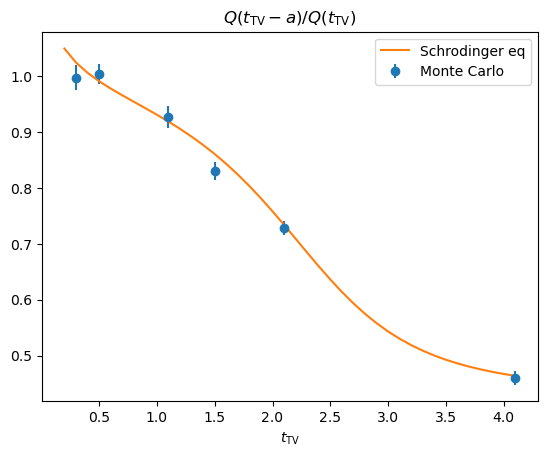

In [37]:
reload(analysis)
reload(ratios_fit)

an = analysis.Analysis(measurements)
measurements.cutoff = 10000
measurements.block_size = 2000
an.data.end = 500000

params_tFV = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 1.0}

t_TVs, ratios, dS_errs = an.plot_exp_Ebar_blocks("tTV", params=params_tFV, get_x=lambda sf: int(measurements.params[sf]["tTV"])*dt, filter_x=lambda t: t>1000, label="Monte Carlo")

plt.plot(np.subtract(t_TVs_sch, 0.0), ddR_div_ddR_a_8_b_9, label="Schrodinger eq")
plt.gca().set_xlabel("$t_\\text{TV}$")
#plt.gca().set_xlim([0,2.1])

plt.legend()

#plt.savefig("Q_over_Q_a_6_b_9.pdf")

Correction factor: 0.21360597971408787
E_FV: 12.621427451413792, E0: 0.7872276454943313, sigma: 1.366530890611646
Covariance: [1.00673818e+10 3.71199392e-01 1.46150685e-01]
[0.30000000000000004, 0.5, 1.1, 1.5, 2.1, 4.1000000000000005]
[0.9967295011378754, 1.002689268297994, 0.9268044226125359, 0.829568929427973, 0.727841929540279, 0.46016921029296853]


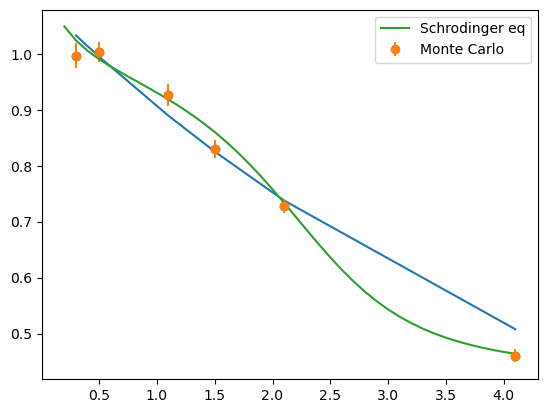

In [38]:
#plt.plot(np.divide(t_TVs_sch, 1), ddR_div_ddR_a_9_b_9, label="Schrodinger eq")
reload(ratios_fit)
fit = ratios_fit.GaussianFit(dt)
start = 0
opt, cov = fit.get_fit_params(np.multiply(t_TVs[start:], 1), ratios[start:], dS_errs[start:], filter_x=lambda t: t<0.1 or t>4)
fit.plot_results(np.multiply(t_TVs[start:], 1), ratios[start:], opt, cov, 1.0, dt=1.0)

plt.errorbar(t_TVs[start:], ratios[start:], yerr=dS_errs[start:], fmt="o", label="Monte Carlo")

plt.plot(np.subtract(t_TVs_sch, 0.0), ddR_div_ddR_a_8_b_9, label="Schrodinger eq")

plt.legend()

print(t_TVs)
print(ratios)
#print(dS_errs)

## Calculate Decay Rate

In [39]:
params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 1.0}
print(an.data.get_indices(params))

['output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_10_tFV_188_tFVout_69_tFVmid_50_*_13-1.bin', 'output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_20_tFV_178_tFVout_64_tFVmid_50_*_13-1.bin', 'output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_2_tFV_196_tFVout_73_tFVmid_50_*_13-1.bin', 'output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_15_tFV_183_tFVout_66_tFVmid_51_*_13-1.bin', 'output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_11_tFV_187_tFVout_68_tFVmid_51_*_13-1.bin', 'output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_

In [52]:
params = {"tTV": 4, "Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 1.0}

print(an.data.get_indices(params))

#Ms = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
#Ls = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 0.2, 0.5, 0.8, 1.0]
Ms = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 1.0]
Ls = [0.0, 0.001, 0.004, 0.008, 0.02, 0.03, 0.04, 0.08, 1.0]

measurements.cutoff = 10000
measurements.block_size = 10000

Q_blocks = an.get_Q_blocks(Ms, Ls, params)
print(f"Q: {jk.get_errors_from_blocks(np.mean(Q_blocks), Q_blocks)}")

['output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_4_tFV_194_tFVout_72_tFVmid_50_*_13-1.bin']
Q: [133.18795272048558, 1.5134121742999131]


In [47]:
reload(analysis)
reload(ratios_fit)
an = analysis.Analysis(measurements)

params = {"tTV": 4, "Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 1.0}
an.data.cutoff = 10000
an.data.block_size = 2000
gamma_mean, gamma_blocks = an.calc_gamma_blocks(Ms, Ls, 0.1, 4.0, params, fitobject=ratios_fit.GaussianFit)
print(f"gamma: {jk.get_errors_from_blocks(gamma_mean, gamma_blocks)}")

IndexError: list index out of range

In [107]:
fit_from_mean, fit_blocks = an.get_fit_ratios_blocks(params, start=0.1, stop=1.0, fitobject=ratios_fit.GaussianFitNoBounds)

Based on mean, ratios fit is: 0.17290700290880925


(array([  1.,   3.,  17.,  31., 181.,  32.,  11.,   3.,   0.,   1.]),
 array([0.17036035, 0.17093124, 0.17150213, 0.17207302, 0.17264391,
        0.1732148 , 0.17378569, 0.17435658, 0.17492747, 0.17549836,
        0.17606925]),
 <BarContainer object of 10 artists>)

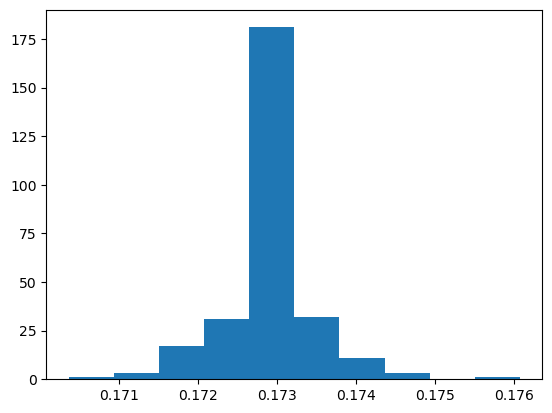

In [108]:
plt.hist(fit_blocks)

## Contribution to Total Error from Each ML-Ratio Ensemble

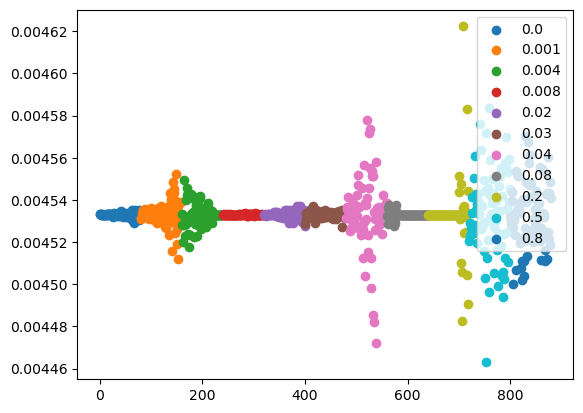

In [118]:
n_blocks_per_ensemble = int((50000 - an.data.cutoff) / an.data.block_size)
labels = Ms[:-1] + Ls[:-1] + Ps[:-1] + ["Fit"]*100
for i in range(int(len(gamma_blocks)/n_blocks_per_ensemble)):
    plt.scatter(np.array(range(n_blocks_per_ensemble)) + i*n_blocks_per_ensemble, gamma_blocks[i*n_blocks_per_ensemble:(i+1)*n_blocks_per_ensemble], label = f"{labels[i]}")
plt.legend()

## Plot P Sub-ratios

output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_1.0_L_0.0_eps_1e-10_offL_False_offM_False_tTV_4_tFV_194_tFVout_72_tFVmid_50_*_13-1.bin
No previous factor found for L=0.0
[0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.9305993884357123, 0.8662042101569483, 0.8064395213338884, 0.7509595208549441, 0.6516022054807592, 0.5658642671807547, 0.49181268536134537, 0.3475723090992692, 0.2468319146051961, 0.17611005050680548, 0.12621613553702485, 0.09084909103670907, 0.06566514190948203, 0.047653942226271846, 0.034718582346271294, 0.01863953185809925, 0.010157350532261711, 0.0056193945858907845, 0.0018098365745125781, 0.00018363158014815767, 7.391401155057568e-05, 5.774386631410386e-05, 5.360149490239572e-05, 5.0560687584372994e-05, 4.808914610093483e-05, 4.603550452995745e-05, 4.4304930512244475e-05, 4.282710955718532e-05, 0.000

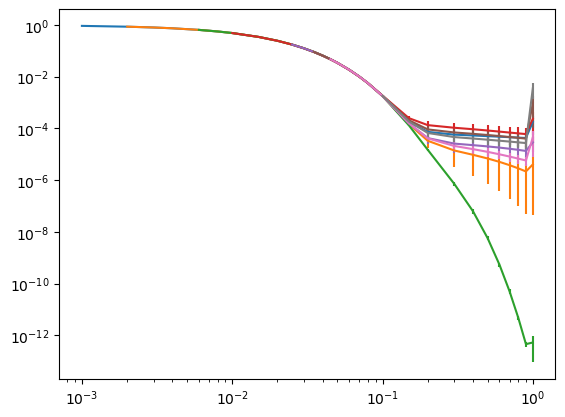

In [50]:
reload(analysis)
an = analysis.Analysis(measurements)
params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0}

an.plot_expS_vs_L(params=params)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

output_data/measurements_1x200_alpha_0.8_beta_9.0_dt_0.1_FVoff_0.3_TVoff_0.0_bar_100.0_M_0.0_L_1.0_eps_1e-10_offL_False_offM_False_tTV_4_tFV_194_tFVout_72_tFVmid_50_*_13-1.bin
No previous factor found for M=0.0
[0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[0.9926901220946106, 0.9854488780783853, 0.9782754903052641, 0.971169191400086, 0.957154841123347, 0.9433998878597987, 0.9298985469351756, 0.8972181294324937, 0.8660038290336644, 0.836176791144837, 0.8076630732061725, 0.7803932984920028, 0.7543023370594242, 0.7293290115047262, 0.7054158254069429, 0.6605568050786227, 0.6193298572003816, 0.581384252164235, 0.514124317660726, 0.38527347362334435, 0.2957231107811504, 0.185035785594127, 0.12361963876022646, 0.08703904327961576, 0.06397158815490796, 0.04872568622075597, 0.03824443141332559, 0.03079328166235375, 0.9999999999999958]
[1.9671202282285623e-05, 3.89961

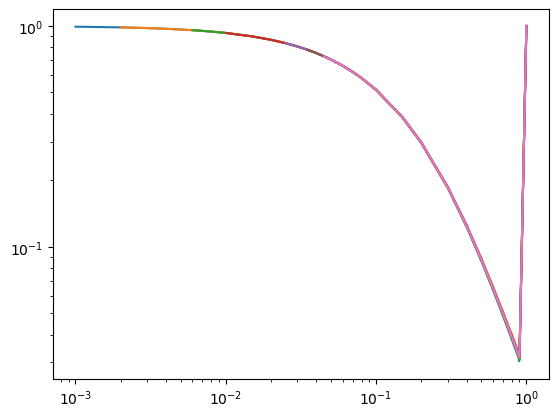

In [51]:
reload(analysis)
an = analysis.Analysis(measurements)
params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "L": 1.0}

an.plot_expS_vs_M(params=params)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')